# DICOM images Rotation

This notebook is dedicated to the 2D rotation of the DICOM patient images.

## Prerequisites

- Python 3.7.x, mine from Anaconda (5.3.1 x64 as of now, https://www.anaconda.com/download/)
- conda update python numpy matplotlib scipy pandas bokeh
- conda update pip
- pip install pydicom (v1.2.2 as of now)
- conda install plotly
- conda install scikit-image (shall be in full Anaconda, if miniConda is installed, you have to install it)

In [67]:
%matplotlib inline

import numpy as np
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize

Some helper thingies

In [68]:
X = 0
Y = 1
Z = 2

def squared(x):
    return x*x

List directory and check and count files

In [69]:
data_path = "D:/Patients/Pt16_RP_20170515"
output_path = working_path = "."
output_dir  = "Out"

# new patient name and ID, not to mess with existing ones,
# if None will be left unchanged
PatientName = None # 'RP001R       ' # = None
PatientID   = None # 'RP001R   '     # = None

l = list(Path(data_path).glob("*.dcm"))

# Print out the first 5 file names to verify we're in the right folder.
print("Total of {0} DICOM images.\nFirst 5 filenames:".format(len(l)))
for p in l[:5]:
    print(f"{p}")

Total of 251 DICOM images.
First 5 filenames:
D:\Patients\Pt16_RP_20170515\1.2.840.113704.1.111.2904.1494855084.10_0002_000001_14948551230000.dcm
D:\Patients\Pt16_RP_20170515\1.2.840.113704.1.111.2904.1494855084.10_0002_000002_14948551230001.dcm
D:\Patients\Pt16_RP_20170515\1.2.840.113704.1.111.2904.1494855084.10_0002_000003_14948551230002.dcm
D:\Patients\Pt16_RP_20170515\1.2.840.113704.1.111.2904.1494855084.10_0002_000004_14948551230003.dcm
D:\Patients\Pt16_RP_20170515\1.2.840.113704.1.111.2904.1494855084.10_0002_000005_14948551240004.dcm


Load all scans, set thickness

In [70]:
def load_scans(path):
    """Here we assume equidistant in Z slices,
       sort output by InstanceNumber"""
    p = Path(path)
    slices = [pydicom.dcmread(str(Path(path)/s)) for s in p.iterdir() if s.is_file()]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.fabs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.fabs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    #for s in slices: # assign all slices the same thickness
    #    s.SliceThickness = slice_thickness
        
    return slices

id = 0
patient = load_scans(data_path)

# ok, put all images together into 3d matrix, test images dimensions as well
images  = np.stack([s.pixel_array for s in patient], axis = Z) # so final set of images would be (512,512,168)
print(f"All images together: {images.shape}")
print(patient[0]) # info from the first slice

All images together: (512, 512, 251)
(0008, 0000) Group Length                        UL: 682
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0012) Instance Creation Date              DA: '20170515'
(0008, 0013) Instance Creation Time              TM: '093210'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.1.111.10036.1494855130.214
(0008, 0020) Study Date                          DA: '20170515'
(0008, 0022) Acquisition Date                    DA: '20170515'
(0008, 0023) Content Date                        DA: '20170515'
(0008, 002a) Acquisition DateTime                DT: '20170515093137-0400'
(0008, 0030) Study Time                          TM: '092926'
(0008, 0032) Acquisition Time                    TM: '093137'
(0008, 0033) Content Time                        TM: '093137.88

Some good checks on what we got there

In [71]:
sth = patient[0].SliceThickness
print(f"Slice Thickness: {sth}")
px0 = patient[0].PixelSpacing[X]
px1 = patient[0].PixelSpacing[Y]
print(f"Pixel Spacing (row, col): ({px0}, {px1})")

Slice Thickness: 1.00
Pixel Spacing (row, col): (1.171875, 1.171875)


More checks - slopes, intercepts, slice positions etc

In [72]:
for k, slice in enumerate(patient):
    minpix = np.min(slice.pixel_array.astype(np.int16))
    maxpix = np.max(slice.pixel_array.astype(np.int16))
    if minpix < 0:
        print(f"Negative value discovered: {k}")
        break
    if maxpix > 4095: # 12 bits scanner
        print(f"12-Positive value discovered:{k}")
        break
        
# now test for different pixel sizes
vx_prev = patient[0].PixelSpacing[X]
vy_prev = patient[0].PixelSpacing[Y]

for k, slice in enumerate(patient):
    vx = slice.PixelSpacing[X]
    vy = slice.PixelSpacing[Y]
    if np.fabs(vx - vx_prev) > 0.001:
        print(f"X pixel values are different:{k}")
        break
    if np.fabs(vy - vy_prev) > 0.001:
        print(f"Y pixel values are different:{k}")
        break
    vy_prev = vy
    vx_prev = vx
    
# now test for slope/intercept
slope_prev = patient[0].RescaleSlope
intrc_prev = patient[0].RescaleIntercept
for k, slice in enumerate(patient):
    slope = slice.RescaleSlope
    intrc = slice.RescaleIntercept
    if np.fabs(slope - slope_prev) > 0.001:
        print(f"Slope values are different:{k}")
        break
    if np.fabs(intrc - intrc_prev) > 0.001:
        print(f"Intercept values are different:{k}")
        break
    intrc_prev = intrc
    slope_prev = slope
    
# now test for position/thickness
patientpos_prev = None
sliceths_prev   = None
sliceloc_prev   = None
for k, slice in enumerate(patient):
    sliceths = slice.SliceThickness
    sliceloc = slice.SliceLocation
    
    if np.fabs( sliceloc - slice.ImagePositionPatient[Z] ) > 0.001:
        print(f"Slice position and patient position are different:{k}")
        break
        
    if k != 0:
        t1 = np.fabs(slice.ImagePositionPatient[Z] - patientpos_prev[Z]) # might be negative
        t2 = sliceths 
        t3 = np.fabs(sliceloc - sliceloc_prev) # might be negative
        
        if np.fabs(t1 - t2) > 0.001:
            print(f"Thickness from SliceThickness and PatientPosition are different:{k}")
        if np.fabs(t1 - t3) > 0.001:
            print(f"Thickness from SliceThickness and SliceLocation are different:{k}")
        
    patientpos_prev = slice.ImagePositionPatient
    sliceths_prev   = sliceths
    sliceloc_prev   = sliceloc

In [73]:
file_used = str(Path(output_path)/f"fullimages_{id}.npy")
np.save(str(Path(output_path)/f"fullimages_{id}.npy"), images)

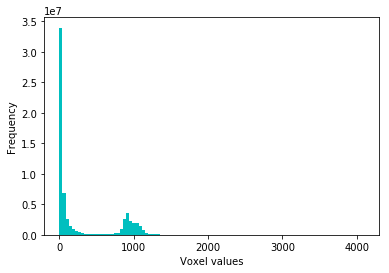

In [74]:
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=100, color='c')
plt.xlabel("Voxel values")
plt.ylabel("Frequency")
plt.show()

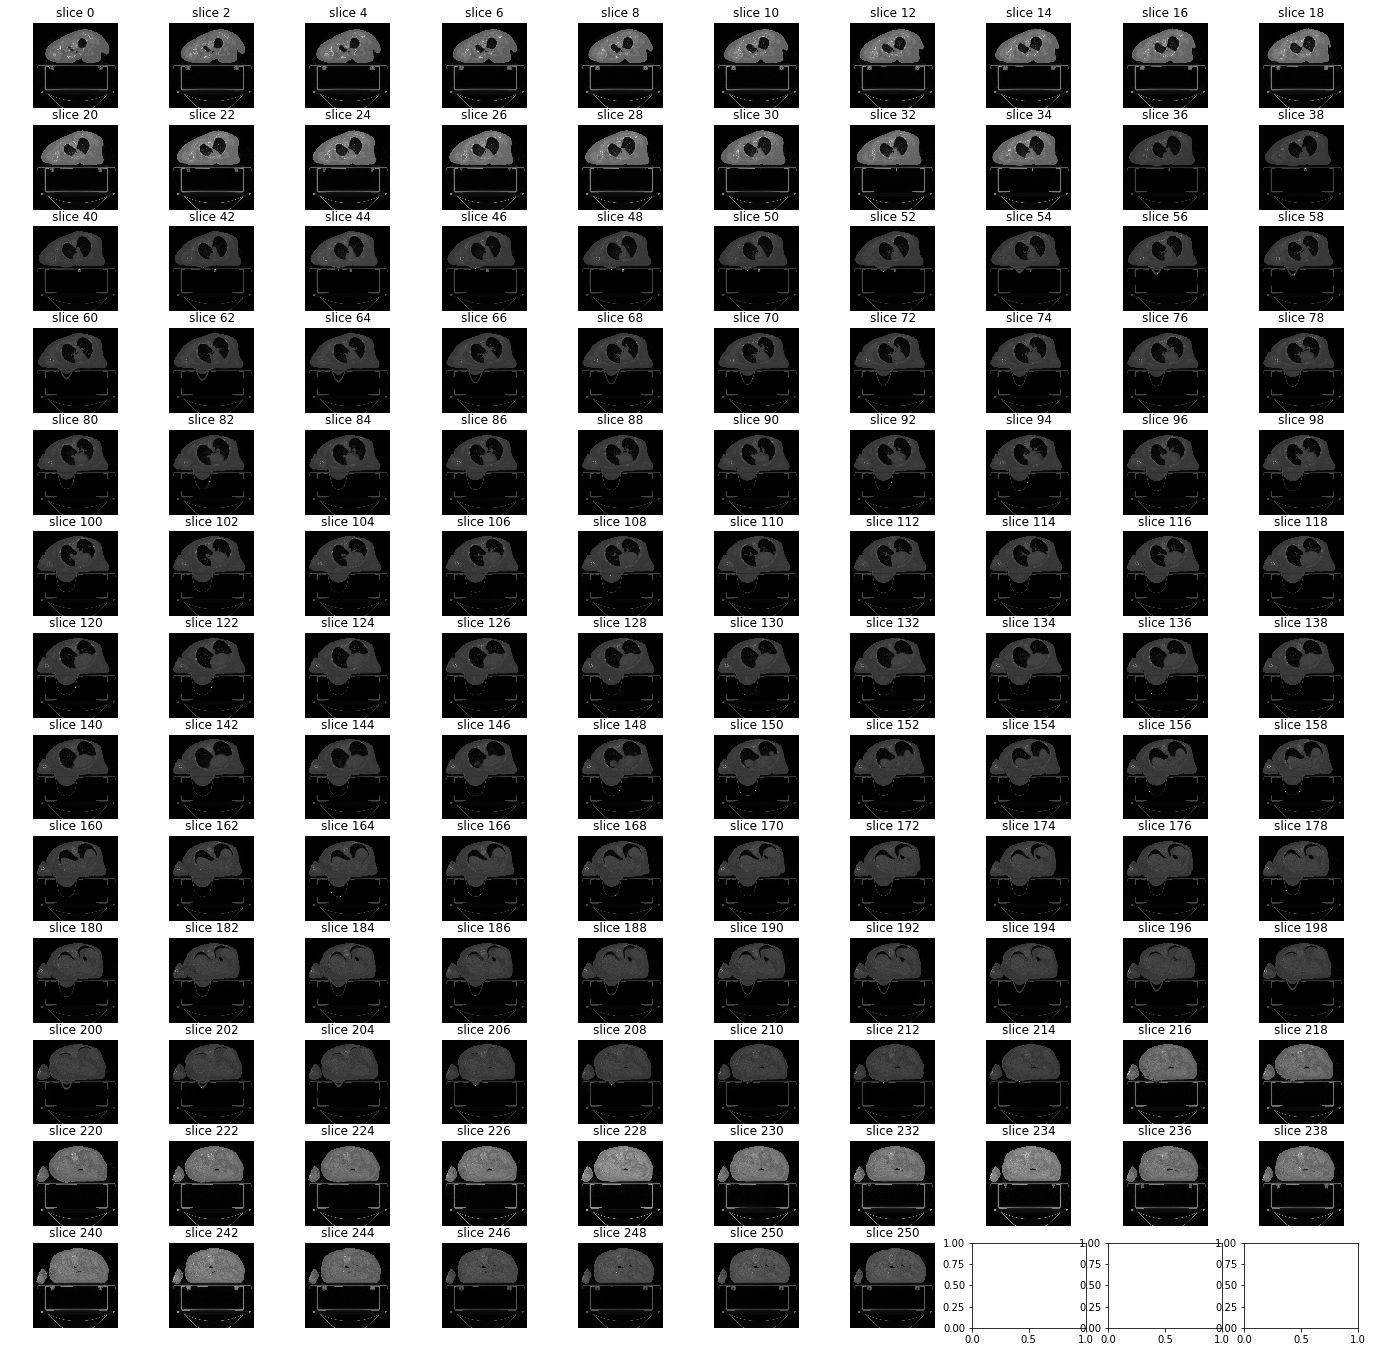

In [75]:
imgs_to_process = np.load(file_used)

def sample_stack(stack, rows=13, cols=10, start_with=0, show_every=2):
    fig,ax = plt.subplots(rows, cols, figsize=[24, 24])
    last = False
    for ir in range(rows):
        for ic in range(cols):
            ind = start_with + (ir*cols + ic)*show_every
            if ind > stack.shape[Z] - 1:
                ind = stack.shape[Z] - 1
                last = True
            
            ax[ir, ic].set_title(f"slice {ind}")
            ax[ir, ic].imshow(stack[:,:,ind], cmap = "gray")
            ax[ir, ic].axis("off")
            if last:
                break
    plt.show()

sample_stack(imgs_to_process)

In [76]:
# new patient image orientation, if None will be left unchanged
angle = -6.0 # degrees
phi   = angle / 180.0 * np.pi # radians
PatientImageOrientation = [np.cos(phi),  np.sin(phi), 0.0,
                           np.sin(phi), -np.cos(phi), 0.0]
PatientImageOrientation = np.round(PatientImageOrientation, 10) # round to float precision
print(f"Desired image orientation: {PatientImageOrientation}")
# uniformity check
PIOnorm = squared(PatientImageOrientation[0]) + squared(PatientImageOrientation[1]) + squared(PatientImageOrientation[2])
if PIOnorm > 1.000001 or PIOnorm < 0.999999:
    print("Something wrong with axis 0 of PatientImageOrientation")
PIOnorm = squared(PatientImageOrientation[3]) + squared(PatientImageOrientation[4]) + squared(PatientImageOrientation[5])
if PIOnorm > 1.000001 or PIOnorm < 0.999999:
    print("Something wrong with axis 1 of PatientImageOrientation")
# orthogonality check
dot = PatientImageOrientation[0]*PatientImageOrientation[3] + PatientImageOrientation[1]*PatientImageOrientation[4] + PatientImageOrientation[2]*PatientImageOrientation[5]
if dot > 0.000001 or dot < -0.000001:
    print("Something wrong with Z axis of PatientImageOrientation, dot product test {0}".format(dot))
crossX = PatientImageOrientation[1]*PatientImageOrientation[5] - PatientImageOrientation[2]*PatientImageOrientation[4]
crossY = PatientImageOrientation[2]*PatientImageOrientation[3] - PatientImageOrientation[0]*PatientImageOrientation[5]
crossZ = PatientImageOrientation[0]*PatientImageOrientation[4] - PatientImageOrientation[1]*PatientImageOrientation[3]
print(f"Cross product: {crossX}, {crossY}, {crossZ}")

Desired image orientation: [ 0.9945219  -0.10452846  0.         -0.10452846 -0.9945219   0.        ]
Cross product: 0.0, -0.0, -1.0000000000698681


In [77]:
imgs_to_process = np.load(file_used)

print(f"Shape before resampling\t{imgs_to_process.shape}")
imgs_after_resamp = scipy.ndimage.interpolation.rotate(imgs_to_process, angle, axes=(1,0), reshape=False)
print(f"Shape after resampling:\t{imgs_after_resamp.shape}")

Shape before resampling	(512, 512, 251)
Shape after resampling:	(512, 512, 251)


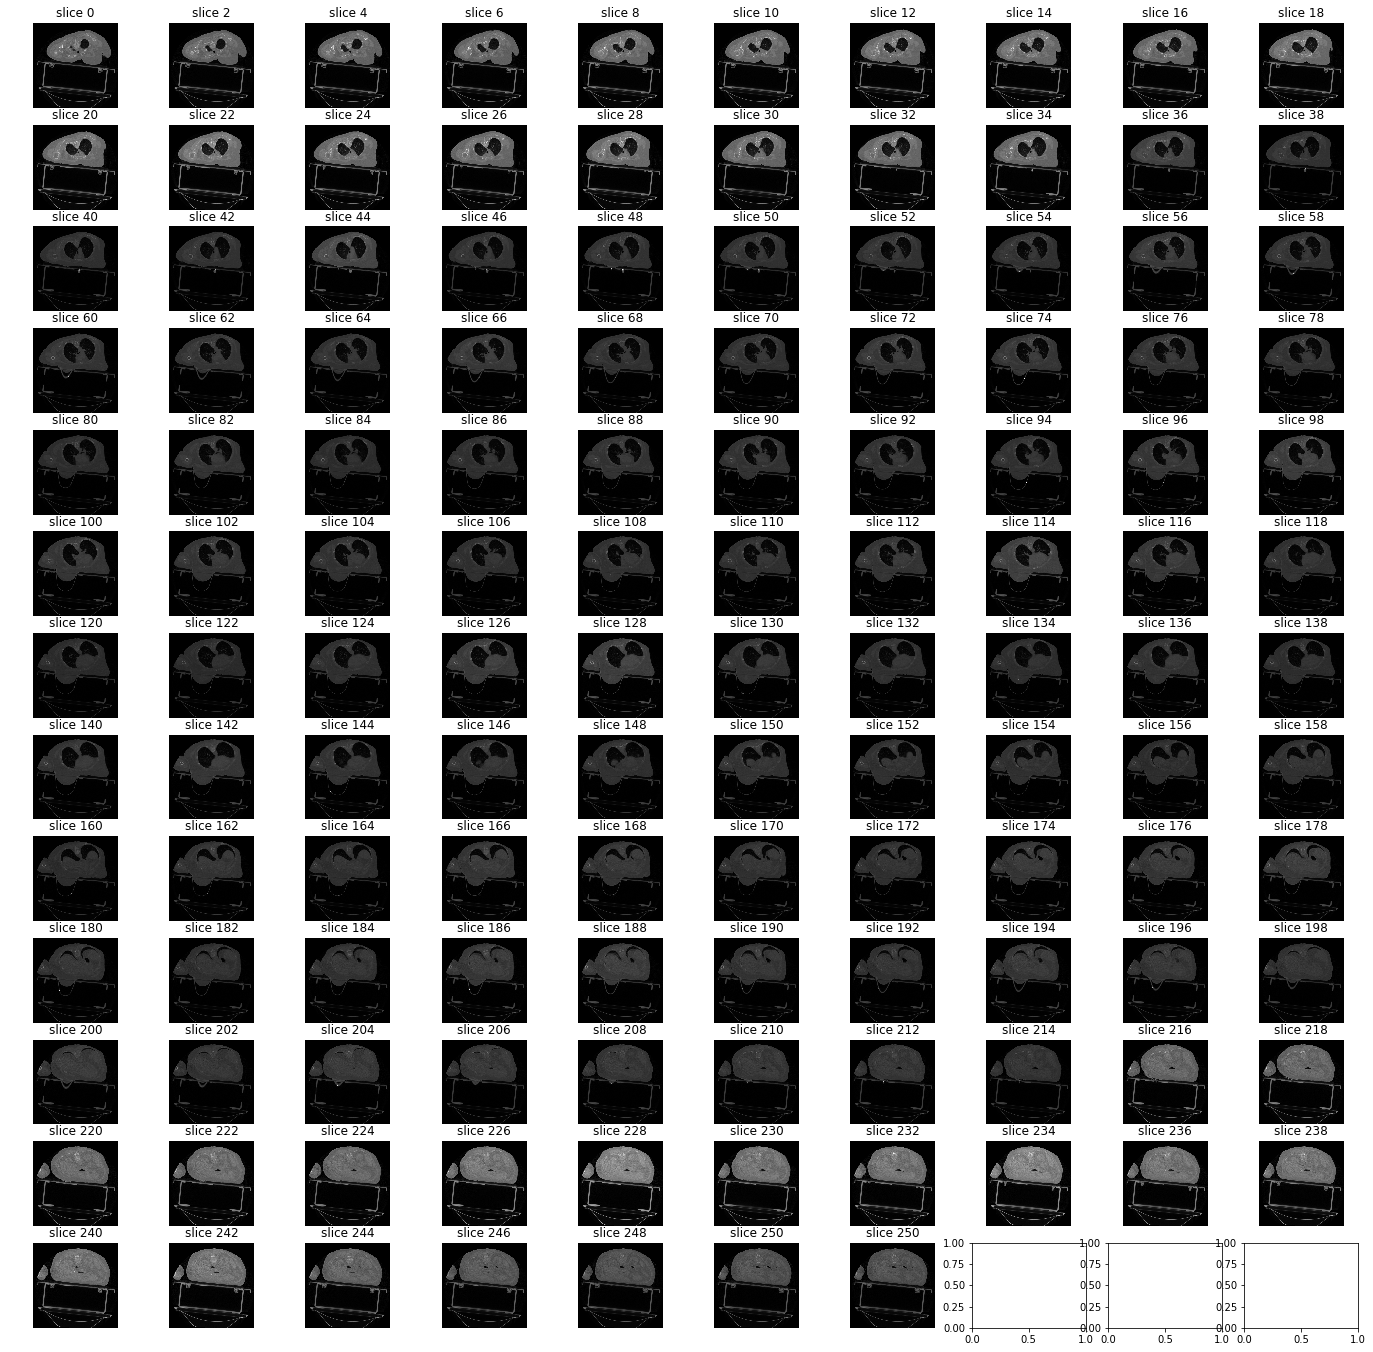

In [78]:
sample_stack(imgs_after_resamp)

In [79]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
for i, slice in enumerate(patient):
    q = imgs_after_resamp[:, :, i]
    slice.PixelData = q.tobytes()
    slice.Rows, slice.Columns = q.shape
    slice.PatientName = slice.PatientName if PatientName is None else PatientName
    slice.PatientID   = slice.PatientID if PatientID is None else PatientID
    if PatientImageOrientation is not None:
        slice.ImageOrientationPatient[0] = PatientImageOrientation[0]
        slice.ImageOrientationPatient[1] = PatientImageOrientation[1]
        slice.ImageOrientationPatient[2] = PatientImageOrientation[2]
        slice.ImageOrientationPatient[3] = PatientImageOrientation[3]
        slice.ImageOrientationPatient[4] = PatientImageOrientation[4]
        slice.ImageOrientationPatient[5] = PatientImageOrientation[5]
    fname = Path(output_dir)/(slice.SeriesInstanceUID + "_" + str(slice.InstanceNumber) + ".dcm")
    pydicom.dcmwrite(str(fname), slice, False)
print("Done!")

Done!


Check output directory for images

### References

- Inspired by https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/.
- See also http://dicomiseasy.blogspot.com/2013/06/getting-oriented-using-image-plane.html